# AM207 Fall '19 Final Project

###  _Variational Inference with Normalizing Flows for Bayesian Neural Networks_

### Brian Chu, Cooper Lorsung, Jovin Leong



---

# Abstract

In Bayesian statistics, Variational Inference (VI) is an important method with myriad applications that enables us to approximate difficult posteriors through optimization. The method involves proposing a simpler distributional family that resembles our target distribution which we can subsequently sample from (Wainwright and Jordan, 2008). A key assumption that is often made in VI is the mean-field assumption in VI approximation—however, as we will shortly see, this is a restrictive and often inappropriate assumption to make.

<br>

Our project examines Mohamed and Rezende's 2015 paper  _Variational Inference with Normalizing Flows_ where the authors seek to resolve this dependence on mean-field approximations through the use of normalizing flows in VI. We, therefore, endeavour to explain and implement key aspects of the proposed approach and, in doing so, we hope  to more clearly express the intuition and reasoning behind the approach and its limitations. We attempt this by creating a pedagogical example to motivate the use of normalizing flows before considering several implementations involving normalizing flows - namely, for distributional approximation and for prediction using Bayesian neural networks. Finally, we conclude with a discussion of the limitations of normalizing flows along with our experience and insights gained from our implementations.

---

# Background
As mentioned above, VI allows for posterior inference of large and complex problems through the use of a distribution $q$ that is relatively easy for us to sample from, where $q$ comes from a family of distributions $Q$ (Hoffman et al., 2013). A frequently used family of approximations is the mean-field variational family, where the latent variables are assumed to be determined by a distinct factor in the variational density and are assumed to be mutually independent (Blei et al., 2018).

<br>

$$q(x) = \prod_{i=1}^{m}q_i(z_i)$$

**<center>Member of the mean-field variational family</center>**

<br>

The mean-field assumption of mutual independence is useful to us in VI as it enables us to, in the optimization of the Evidence Lower Bound (ELBO) for a proposal distribution $q(\phi)$, assume that the joint $q(\phi)$ factorizes completely over each dimension of $\phi$. The assumption enables us to easily capture the marginal density of latent variables and rewrite the expectation in the ELBO over all $\phi_i$s jointly as the iterated expectation.

However, this assumption is problematic because it fails to capture any correlation between our variables. The mean-field assumption, by construction, assumes away any correlation between variables. In cases where our posterior density exhibits correlation, although our variational approximation with the mean-field assumption might have the same mean as our posterior density, the covariance structure will (as a consequence of our assumption) be decoupled (Blei et al., 2018).

Another consequence of using mean-field variational approximation is that the Kullback-Leibler divergence (as illustrated below), that is used in our optimization, results in the underrepresentation of the posterior variance.

<br>

$$D_{KL} [q(z)||p(z | x)] = E[log q(z)] − E[log p(z | x)]$$
**<center>Kullback-Leibler divergence</center>**

<br>
  
As such, Mohamed and Rezende's 2015 paper proposes an alternative approach to performing VI: VI through the use of normalizing flows.

Normalizing flows refer to an approach where we take a relatively simple base distribution and perform a series of invertible mappings such that, at the end of these transformations, we arrive at an approximation of our posterior. Mohamed and Rezende propose the use of normalizing flows as an alternative approach to flexibly approximating posteriors through VI. Their approach enables us to perform VI without having to make the mean-field assumption.

To illustrate this, we will produce pedagogical examples to illustrate the limitations of using mean-field variational families in VI and how normalizing flows can be used to approximate a posterior distribution. We also perform a rudimentary implementation of Mohamed and Rezende's approach.

In subsequent sections, we further explore the approach of using VI with normalizing flows in greater detail and examine the boundaries of this approach through a more sophisticated implementation. 

Finally, we conclude our study with an evaluation and discussion of Mohamed and Rezende's approach by making comparisons to alternative approaches.



---

# Pedagogical Example: Variational Inference with Mean Field Assumption

In our example below, we implement Black Box Variational Inference (BBVI) for a posterior approximation to illustrate an instance where VI with the mean-field assumption breaks down.

<br>
We begin by generating data that follows an anisotropic Gaussian and we subsequently use our BBVI implementation to approximate our posterior distribution. Following that, we calculate our analytical mean and variances in order to visualize the posterior distribution which we overlay with our BBVI approximation for the purposes of evaluation.


In [1]:
import itertools
import numpy
import pandas as pd
import autograd.numpy.random as npr
from autograd import grad
from autograd import numpy as np
from autograd.misc.optimizers import adam, sgd
from autograd.scipy.stats import multivariate_normal, norm
from autograd import scipy as sp
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import multivariate_normal as mvn
from IPython.display import HTML

%matplotlib inline

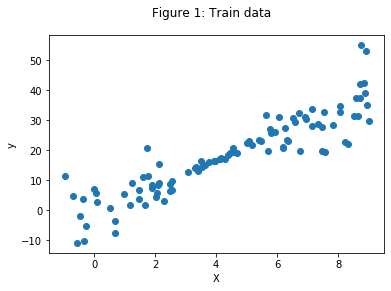

In [2]:
def f(x):
    return np.random.normal(5, 1)*x + np.random.normal(0, 2*np.abs(x-4))

x_pos = np.random.uniform(-1, 9, 100)
y_pos = f(x_pos)
fig, ax = plt.subplots()
ax.scatter(x_pos, y_pos)
plt.xlabel('X')
plt.ylabel('y')
plt.suptitle('Figure 1: Train data')
plt.show()

We assume that the outcome $y$ can be modeled by the following process:


\begin{aligned}
y &= f(x) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.5)\\
f(x) &= w_1x + w_0 \\
w_0 &\sim \mathcal{N}(0, 1)\\
w_1 &\sim \mathcal{N}(0, 0.5)
\end{aligned}



In this model, we assume the same likelihood as before, but we also include the following priors for $w_0$ and $w_1$: 

\begin{aligned}
&p(w_0) = \mathcal{N}(0, 1) \\
&p(w_1) = \mathcal{N}(0, 0.5)
\end{aligned}

In [3]:
x = np.copy(x_pos)
y = np.copy(y_pos)

sig_inv = np.array([[2,0],[0,1]]) # Inverse coviariance of w0, w1

# Create X, y is already in a suitable form
X = np.zeros((len(x),2))
X[:,0] = 1
X[:,1] = x

# Calculate mean and variance according to formula derived above
cov = np.linalg.inv(2*np.dot(X.T, X) + sig_inv)
mean = 2*np.dot(np.dot(y.T, X), cov)

factor = 40
w0_lims = sorted([mean[0] + factor*cov[0][0]*mean[0], mean[0] - factor*cov[0][0]*mean[0]])
w1_lims = sorted([mean[1] + factor*cov[1][1]*mean[1], mean[1] - factor*cov[1][1]*mean[1]])

# Grid of points for heatmap, based on confidence intervals in part 1
gridsize = 50
#w0 = np.linspace(8.6, 9.1, gridsize)
#w1 = np.linspace(5.16, 5.3, gridsize)
w0 = np.linspace(*w0_lims, gridsize)
w1 = np.linspace(*w1_lims, gridsize)
grid = [el for el in itertools.product(w0, w1)]

# Create multivariate gaussian and sample on a grid
print("ANALYTICAL MEAN: {}".format(mean))
print("\nANALYTICAL COVARAINCE: {}".format(cov))
multi_norm = mvn(mean, cov)
vals = multi_norm.pdf(grid)

# Calculate probabilities and marginals
W0, W1 = np.meshgrid(w0, w1)
vals = np.reshape(vals, (50,50))
w0_marginals = np.sum(vals, axis=0)
w1_marginals = np.sum(vals, axis=1)
normalization = np.sum(vals)
ticks = [0, 9, 19, 29, 39, 49]

ANALYTICAL MEAN: [0.4113949  4.07118614]

ANALYTICAL COVARAINCE: [[ 0.01614868 -0.00256901]
 [-0.00256901  0.00058937]]


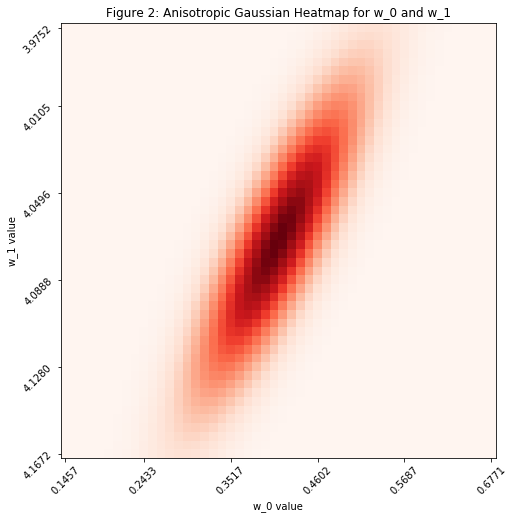

In [4]:
fig, ax = plt.subplots(figsize=(8,8))

ax.imshow(vals, cmap="Reds")
ax.set(xticks=ticks, xlabel='w_0 value', yticks=ticks, ylabel='w_1 value',
       title='Figure 2: Anisotropic Gaussian Heatmap for w_0 and w_1')
ax.set_xticklabels(["{0:.4f}".format(v) for v in W0[0][ticks]], rotation=45)
ax.set_yticklabels(["{0:.4f}".format(v) for v in W1[:,0][ticks]], rotation=45)
plt.show()

In [5]:
def black_box_variational_inference(logprob, D, num_samples):
    """Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557"""

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params
    
def variational_inference(sigmaw, sigmay, y_train, x_train, S, max_iteration, step_size, verbose):
    '''implements wrapper for variational inference via bbb for bayesian regression'''
    D = 2
    variational_dim = D
    #sigmay_inv = np.linalg.inv(sigmay)
    #sigmay_det = np.linalg.det(sigmay)

    
    def log_prior(w):
        w = w[0]
        constant_w = -0.5*(np.log(2*np.pi) + np.log(sigmaw[0]))
        constant_w += -0.5*(np.log(2*np.pi) + np.log(sigmaw[1]))
        
        exponential_w = -0.5 * w[0]**2/sigmaw[0]**2
        exponential_w += -0.5 * w[1]**2/sigmaw[1]**2
        #return np.log(norm.pdf(w[0], 0, sigmaw[0])) + np.log(norm.pdf(w[1], 0, sigmaw[1]))
        return constant_w + exponential_w
        

    def log_likelihood(w):
        minibatches = len(w)
        w = w[0]
        if(minibatches==1):
            w = [w.T]
        w = np.array(w)
        mv_mean = np.dot(X, w.T)
        #print(mv_mean.shape)
        #return np.log(multivariate_normal.pdf(y, mean=mv_mean, cov=sigmay*np.eye(len(y))))
    
        constant = -0.5 * (np.log(2 * np.pi) + np.log(sigmay))*minibatches
        exponential = sum([-0.5*1/(sigmay) * np.dot((y - np.dot(X, w[i])).T, (y-np.dot(X,w[i]))) for i in range(minibatches)])
        return constant + exponential
    
    log_density = lambda w, t: log_likelihood(w) + log_prior(w)

    #build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if(verbose and t!=0):
            if  t % 1000 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

    print("Optimizing variational parameters...")
    #initialize variational parameters
    init_mean = np.copy(mean)
    #init_mean = 3*np.ones(D)
    init_log_std = np.log([0.5*cov[0][0], 0.5*cov[1][1]])
    #init_log_std = -10*np.ones(D)
    
    init_var_params = np.concatenate([init_mean, init_log_std])
    print("INIT VAR PARAMS: {}".format(init_var_params))
    
    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)
    
    return variational_params 


In [6]:
sigmaw = np.diag([1, 2])
sigmaw = np.array([1, 2])
sigmay = 0.5
params = variational_inference(sigmaw, sigmay, y, x, 1, 20000, 1e-3, True)

Optimizing variational parameters...
INIT VAR PARAMS: [ 0.4113949   4.07118614 -4.81906425 -8.12961145]
Iteration 1000 lower bound -2893.901526742432; gradient mag: 8.2351877548906
Iteration 2000 lower bound -2892.103256785361; gradient mag: 12.963164521809121
Iteration 3000 lower bound -2890.8218638052313; gradient mag: 28.81926561371072
Iteration 4000 lower bound -2890.776154825377; gradient mag: 166.5844446349826
Iteration 5000 lower bound -2890.3838146988705; gradient mag: 167.46429088370527
Iteration 6000 lower bound -2890.5771461681297; gradient mag: 47.18376440234577
Iteration 7000 lower bound -2891.1724970097025; gradient mag: 27.424021597256864
Iteration 8000 lower bound -2889.931419213583; gradient mag: 115.16533961104481
Iteration 9000 lower bound -2893.0137735887183; gradient mag: 65.23502497434387
Iteration 10000 lower bound -2890.047617375744; gradient mag: 59.464062896197674
Iteration 11000 lower bound -2890.453897722975; gradient mag: 35.95958928536053
Iteration 12000 l

In [7]:
# Obtain values for analytical and variational mean and covaraince
variational_mean = params[:2]
variational_cov = np.exp(params[2:])**2
print("ANALYTICAL MEAN:\n{}\n\nANALYTICAL COVARIANCE:\n{}".format(mean, cov))
print("\nVARIATIONAL MEAN:\n{}\n\nVARIATIONAL VARIANCE:\n{}".format(variational_mean, variational_cov))

ANALYTICAL MEAN:
[0.4113949  4.07118614]

ANALYTICAL COVARIANCE:
[[ 0.01614868 -0.00256901]
 [-0.00256901  0.00058937]]

VARIATIONAL MEAN:
[0.410709   4.07242566]

VARIATIONAL VARIANCE:
[0.00501971 0.00017382]


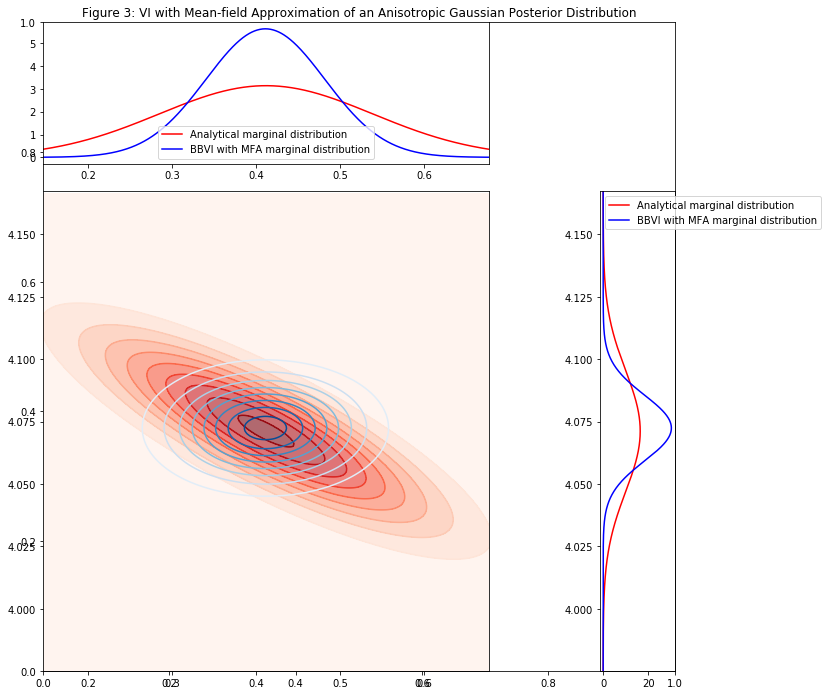

In [8]:
x_grid, y_grid = numpy.mgrid[w0_lims[0]:w0_lims[1]:.001, w1_lims[0]:w1_lims[1]:.001]
pos = numpy.dstack((x_grid, y_grid))
z_p = multivariate_normal.pdf(pos, mean, cov)
z_q = multivariate_normal.pdf(pos, variational_mean, variational_cov)

# Plotting analytical vs MFA posterior
fig = plt.figure(figsize=(10,10))
plt.title("Figure 3: VI with Mean-field Approximation of an Anisotropic Gaussian Posterior Distribution")
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[1:4, 0:3])
ax_joint.set(xlim=w0_lims, ylim=w1_lims)
ax_joint.contour(x_grid, y_grid, z_p, levels=10, cmap='Reds')
ax_joint.contourf(x_grid, y_grid, z_p, levels=10, cmap='Reds', alpha=0.6)
ax_joint.contour(x_grid, y_grid, z_q, levels=10, cmap='Blues')

ax_marg_x = fig.add_subplot(gs[0, 0:3])
x_marginal = np.linspace(*w0_lims, 1000)
ax_marg_x.set(xlim=w0_lims)
ax_marg_x.plot(x_marginal, norm.pdf(x_marginal, mean[0], np.sqrt(cov[0][0])), color='r', label="Analytical marginal distribution")
ax_marg_x.plot(x_marginal, norm.pdf(x_marginal, variational_mean[0], np.sqrt(variational_cov[0])), color='b', label="BBVI with MFA marginal distribution")
ax_marg_x.legend()

ax_marg_y = fig.add_subplot(gs[1:4, 3])
y_marginal = np.linspace(*w1_lims, 1000)
ax_marg_y.set(ylim=w1_lims)
ax_marg_y.plot(norm.pdf(y_marginal, mean[1], np.sqrt(cov[1][1])), y_marginal, color='r', label="Analytical marginal distribution")
ax_marg_y.plot(norm.pdf(y_marginal, variational_mean[1], np.sqrt(variational_cov[1])), y_marginal, color='b', label="BBVI with MFA marginal distribution")
ax_marg_y.legend()

plt.tight_layout()
plt.show()

As can be observed from the above plot, BBVI does a poor job of approximating an anisotropic Gaussian. 

<br>

From the heatmaps, we see that although the BBVI is able to have the same mean as the original density, the approximation fails to capture the covariance structure of the posterior. From the marginal distribution plots of both $w_0$ and $w_1$, the BBVI approximation places more mass about the mean and does not capture the tailedness of our posterior distribution.

<br>

We can see from the contour plot that BBVI with mean-field approximation is unable to capture the “ovalness” of our actual distribution. BBVI approximates our distribution using an isotropic normal distribution, which has no covariance between variables. However, the actual distribution has non-zero off-diagonal entries in the covariance matrix. When we look closer at the marginal distributions of w0 and w1, we can see that both BBVI and the actual distribution have normal distributions for the two variables. However, one of the goals of using a distribution is to be able to estimate uncertainty and not rely solely on a point estimate. The marginal distribution of BBVI has a much lower standard deviation compared to the actual distribution. This means that when we try to estimate our uncertainty using its approximation, we will be severely overconfident in our point estimate.

<br>

We now continue into the second part of our pedagogical example where we perform a rudimentary implementation of Mohamed and Rezende's proposed approach using normalizing flows.

---

# Pedagogical Example: Normalizing flows

Our pedagogical example here illustrates how normalizing flows might be used for variational inference of a posterior distribution; as such, for the purposes of this illustration, we perform a rudimentary implementation involving a single fixed flow that does not require training our flow on our data.

<br>

Our flow, here, consists of an analytically derived function that takes in the analytical covariance of our posterior and performs affine transformations on our samples obtained from our proposed distribution (a standard Gaussian distribution); this process is essentially akin to implementing a planar flow analytically.

<br>

We first define our single fixed flow as a function ```find_L``` which takes in as input the analytical covariance matrix and outputs a transformation matrix that is essentially our 'flow function'.

In [9]:
# Normalizing flow
def find_L(cov):
    sig1 = cov[0][0]
    sig2 = cov[0][1]
    sig4 = cov[1][1]
    return np.array([[np.sqrt(sig1), 0], [sig2/np.sqrt(sig1), np.sqrt(sig4 - sig2**2/sig1)]])

num_samples = 100

x_grid, y_grid = numpy.mgrid[w0_lims[0]:w0_lims[1]:.001, w1_lims[0]:w1_lims[1]:.001]
pos = numpy.dstack((x_grid, y_grid))
analytical = np.random.multivariate_normal(mean, cov, 2000)
pre_flow = np.random.multivariate_normal([0,0], [[1,0],[0,1]], 2000)
post_flow = np.zeros(pre_flow.shape)

L = find_L(cov)
print("L: {}".format(L))
for i, s in enumerate(pre_flow):
    post_flow[i] = np.dot(L, s) + mean

x_grid, y_grid = numpy.mgrid[w0_lims[0]:w0_lims[1]:.001, w1_lims[0]:w1_lims[1]:.001]
pos = numpy.dstack((x_grid, y_grid))
z_nf = multivariate_normal.pdf(pos, mean, np.dot(L, np.dot(np.eye(2), L.T)), num_samples)
z_p = multivariate_normal.pdf(pos, mean, cov)
nf_cov = np.dot(L, np.dot(np.eye(2), L.T))

L: [[ 0.12707745  0.        ]
 [-0.02021611  0.01344151]]


The analytical form of a planar transformation is: 

$$ f(\textbf{z}) = \textbf{z} + \textbf{u}h(\textbf{w}^T\textbf{z} + b)$$

Where $\textbf{u} \in \mathbb{R}^D$, $\textbf{w} \in \mathbb{R}^D$, $b \in \textbf{R}$, and $h$ is an element-wise nonlinearity. In the case of an affine transformation from an isotropic multivariate Gaussian to an anisotropic multivariate Gaussian, we transform samples according to: 

$$f(\textbf{z}) = L\textbf{z} + \mu$$

Where $L$ is a $2x2$ matrix that transforms an identity matrix into the analytical covariance matrix as $L\mathbb{I}L^T = \Sigma$, and $\mu$ is the analytical mean.

Our transformation of the isotropic multivariate Gaussian to our target distribution, as such can be understood as a planar flow and will be used for the purposes of our pedagogical example; in subsequent sections, we consider other flows.

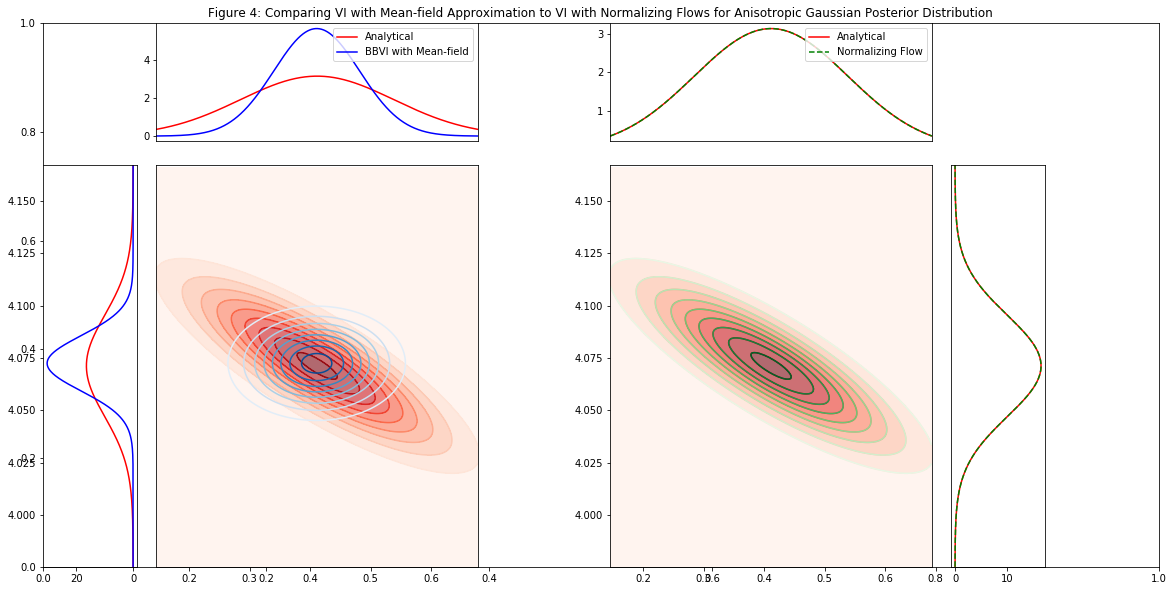

In [10]:
# Plot both approximations overlaid on the posterior distribution for comparison
fig = plt.figure(figsize=(20,10))
plt.title("Figure 4: Comparing VI with Mean-field Approximation to VI with Normalizing Flows for Anisotropic Gaussian Posterior Distribution")
gs = GridSpec(4,10)
ax_joint = fig.add_subplot(gs[1:4, 1:4])
ax_joint.set(xlim=w0_lims, ylim=w1_lims, yticks=[])
ax_joint.contour(x_grid, y_grid, z_p, levels=10, cmap='Reds')
ax_joint.contourf(x_grid, y_grid, z_p, levels=10, cmap='Reds', alpha=0.6)
ax_joint.contour(x_grid, y_grid, z_q, levels=10, cmap='Blues')

ax_marg_x = fig.add_subplot(gs[0, 1:4])
x_marginal = np.linspace(*w0_lims, 1000)
ax_marg_x.set(xlim=w0_lims, xticks=[])
ax_marg_x.plot(x_marginal, norm.pdf(x_marginal, mean[0], np.sqrt(cov[0][0])), color='r', label="Analytical")
ax_marg_x.plot(x_marginal, norm.pdf(x_marginal, variational_mean[0], np.sqrt(variational_cov[0])), color='b', label="BBVI with Mean-field")
ax_marg_x.legend(loc='upper right')

ax_marg_y = fig.add_subplot(gs[1:4, 0])
y_marginal = np.linspace(*w1_lims, 1000)
ax_marg_y.set(ylim=w1_lims)
ax_marg_y.invert_xaxis()
ax_marg_y.plot(norm.pdf(y_marginal, mean[1], np.sqrt(cov[1][1])), y_marginal, color='r')
ax_marg_y.plot(norm.pdf(y_marginal, variational_mean[1], np.sqrt(variational_cov[1])), y_marginal, color='b')

ax_nf = fig.add_subplot(gs[1:4, 5:8])
ax_nf.set(xlim=w0_lims, ylim=w1_lims)
ax_nf.contour(x_grid, y_grid, z_p, levels=10, cmap='Reds')
ax_nf.contourf(x_grid, y_grid, z_p, levels=10, cmap='Reds', alpha=0.6)
ax_nf.contour(x_grid, y_grid, z_nf, levels=10, cmap="Greens")

nax_marg_x = fig.add_subplot(gs[0, 5:8])
nx_marginal = np.linspace(*w0_lims, 1000)
nax_marg_x.set(xlim=w0_lims, xticks=[])
nax_marg_x.plot(x_marginal, norm.pdf(x_marginal, mean[0], np.sqrt(cov[0][0])), color='r', label="Analytical")
nax_marg_x.plot(x_marginal, norm.pdf(x_marginal, mean[0], np.sqrt(nf_cov[0][0])), color='g', linestyle='--', label="Normalizing Flow")
nax_marg_x.legend(loc='upper right')

nax_marg_y = fig.add_subplot(gs[1:4, 8])
ny_marginal = np.linspace(*w1_lims, 1000)
nax_marg_y.set(ylim=w1_lims, yticks=[])
nax_marg_y.plot(norm.pdf(y_marginal, mean[1], np.sqrt(cov[1][1])), y_marginal, color='r')
nax_marg_y.plot(norm.pdf(y_marginal, mean[1], np.sqrt(nf_cov[1][1])), y_marginal, color='g', linestyle='--')

plt.show()

Evidently, from our above plots, our VI using our fixed flows provides us with a much better approximation of our anisotropic Gaussian posterior in comparison to our black box VI approximation. A key reason for this is that the approach of using normalizing flows for VI is such that our posterior approximation is able to capture the inherent covariance in our data and is thus able to side-step some of the problematic implications of the mean-field assumption. We have, therefore, sufficiently shown that in at least some cases, VI with normalizing flows can outperform VI using the mean-field assumption.

<br>

That being said, our approach taken here is very much different from the one taken by Mohamed and Rezende. In their case, instead of using fixed planar flows, they employ a neural network to learn what the flows should be in order to approximate the posterior from the base distribution rather than manually deriving the flow analytically. As such, we will now attempt a more complex implementation of normalizing flows using a neural network for VI.

---

# Implementation: Linear Flows for distribution approximation

Before we attempt an implementation involving Bayesian neural networks  (BNNs), we first attempt to implement normalizing flows to approximate a target distribution and illustrate some of our considerations and processes that motivate our final implementation.

<br>

In this case, we consider the use of linear flows for approximation (as opposed to planar or radial flows); we use linear flows in order to flow from a chosen distribution (in the following cases, a standard normal distribution) to our target distribution. 

The analytical form of a linear transformation is: 
$$ f(\textbf{z}) = A\textbf{z} + B$$
where $A, B \in \mathbb{R}^D$. 

<br>

Our implementation of linear flows to approximate a target distribution is left in a separate Python script given how a lot of the code is essentially repeated in our subsequent implementation below.

Evidently, from our plots below, we observe that the implementation of linear flows basically fails to adequately approximate our target distribution. With different flow parameters, we see that the linear flows either returns a distribution in between the modes (as per in Figure 5) or it captures only one of the modes.

<img src="./img/mode_flattening.png">

<center><b>Figure 5: Approximation of bimodal distribution with linear flow I</b></center>


<img src="./img/Linear_Flows_II.png">
<center><b>Figure 6: Approximation of bimodal distribution with linear flow II</b></center>

As such, it is clear from our implementation above that linear flows basically break down when attempting to approximate multimodal distributions and that this is the case even if with reparameterization. The reason for this is that linear flow transformations cannot fundamentally change the base shape of our initial distribution. The linear flows are only able to scale, shift, and skew our initial distribution and they, therefore, lack the sophistication necessary to approximate multimodal and more complicated distributions. We now consider planar flows for distribution approximations.

---


# Implementation: Planar Flows for density approximation

In a similar vein, we implement planar flows in order to flow from a chosen distribution (in the following cases, a standard normal distribution) to our target distribution. We first attempt to perform density approximation of unnormalized 2D densities so as to recreate the toy examples from Mohamed and Rezende's original paper. As before, because the following implementation is merely a precursor to our subsequent implementation in a Bayesian neural network, the code is left on a separate script.

<br>


<img src="./img/two_moon.png">

<center><b>Figure 7: Two moons toy example</b></center>

<img src="./img/fit_sine.png">

<center><b>Figure 8: Sine curve toy example</b></center>


In both cases, we see that our final planar flow implementation is able to make high-quality approximations. As reported in Mohamed and Rezende's examples, the quality of said approximations, we find, are significantly impacted by flow parameters such as flow length, number of iterations, and step size. The parameter specification often incurs a trade-off between approximation accuracy and computational cost; nevertheless, our trials indicate the success of our planar flow implementation. We illustrate the process of learning flows to flow from a standard normal distribution into the 'Two Moons' toy example through the video below; the video illustrates the flows required to transform our standard normal into our target distribution being learnt by our implementation.

In [11]:
HTML("""
<video width="800" height="600" controls>
  <source src="./img/learning_flows.mp4" type="video/mp4">
</video>
""")


In the two cases below, we attempt a tri-modal distribution with narrow peaks. In the first case, we run it with a similar number of iterations, samples, and flows as per in the earlier toy example cases (10 flows, 1000 samples, 10000 iterations). However, what is observed is that the approximation quality is not great; the three peaks themselves are poorly captured and we can see that the approximated distribution exhibits positive kurtosis.


<img src="./img/adam_fit.png">

<center><b>Figure 9: Three peaks: poor fit</b></center>

However, by increasing the number of flows, samples, and iterations significantly (70 flow, 10000 samples, 20000 iterations) we see that the planar flows implementation is able to generate a much better approximation that is able to more accurately capture our ground-truth distribution. As can be observed from our plot below, it seems like the success of planar flows at approximating a given distribution is largely dependent on the flow parameters (since we are only able to recover the target distribution by changing up our parameters dramatically). 

<img src="./img/three_peaks.png">

<center><b>Figure 10: Three peaks: improved fit</b></center>

Given these results, we can hypothesize that perhaps normalizing flows (or planar flows, specifically) might not be suitable for the approximation of certain distributions that possess certain features. Conceivably, were we to have a target distribution with even more narrow peaks, the computational cost of obtaining a high-quality approximation through our planar flow implementation might prove to be infeasible.

We now extend our existing implementation such that it can be used to perform variational inference in the context of a Bayesian neural network.

---

# Implementation: Planar flows for prediction with Bayesian Neural Networks

In this section, we attempt an implementation of normalizing flows for variation inference in the context of a Bayesian neural network. 

<br>

A Bayesian neural network (BNN) can be described as a non-parametric model that incorporates a prior distribution on its weights. A BNN is distinct from other frequentist approaches in that beliefs derived from background knowledge are incoporated and used to select a prior probability distribution for model parameters. Additionally, predictions made by the BNN involve the intergation of the model's predictions with respect to the posterior parameter distribution that we obtain by updating the aforementioned prior to account for the data (Neal, 2012).

In our context, the BNN is used as a Bayesian model for regression that uses a nerual network to capture the relationship between $X$ and $Y$. As highlighted in the project abstract, BNNs require posterior approximation; this approximation is often achieved through variational inference. Variational inference, in turn, can be carried out through several means. In our following implementation, we consider the use of normalizing flows for variational inference and contrast the results with variational inference using black box variational inference (BBVI) and Hamiltonian Monte Carlo (HMC) sampling; a comparative evaluation of the performance of the different approaches is made later on.

<br>

### Normalizing flows

We first extend our implementation of normalizing flows to approximate our posterior as follows:

In [12]:
# We first define several key functions required for our subsequent NFVI here
def energy_bound(lambda_flows, z, h, u_func, beta=1., bnn=False):
    '''
        Energy bound formula from the paper. We exclude the initial sampling contribution
        because it is independent of flow parameters.
    '''
    D = (lambda_flows.shape[1]-1)//2
    initial_exp = 0
    if(bnn):
        joint_exp = beta*np.mean(u_func(flow_samples(lambda_flows, z, h)))
    else:
        joint_exp = beta*np.mean(np.log(u_func(flow_samples(lambda_flows, z, h).reshape(1, -1, 2))))

    # log-determinant-jacobian contribution from the paper
    flow_exp = 0
    for k, lambda_flow in enumerate(lambda_flows):
        flow_exp = flow_exp + \
                   np.mean(np.log(np.abs(1 + np.dot(psi(lambda_flow, z, h), lambda_flow[:D]))))
        z = flow_once(lambda_flow, z, h)

    # Store probabilities for plotting and analysis
    e_bound.append((initial_exp - joint_exp - flow_exp)._value)
    joint_probs.append(joint_exp._value)
    flow_probs.append(flow_exp._value)
    return initial_exp - joint_exp - flow_exp


def adam_solve(lambda_flows, grad_energy_bound, samples, u_func, h, m=1000, step_size=0.001,
               bnn=False):
    '''
        Uses adam solver to optimize the energy bound
    '''
    output = np.copy(lambda_flows) # Copies to avoid changing initial conditions
    print("BEFORE LEARNING:\n{}".format(output))
    grad_energy_bound = autograd.grad(energy_bound)  # Autograd gradient of energy
    g_eb = lambda lambda_flows, i: grad_energy_bound(lambda_flows, samples, h, u_func, 
                                                     #beta= (0.1 + i/1000))
                                                     beta=min(2, i/1000), # Annealing
                                                     #beta=min(1, 0.01+i/10000),
                                                     bnn=bnn) # Annealing
    output = adam(g_eb, output, num_iters=m, callback=callback, step_size=step_size)
    print("\nAFTER LEARNING:\n{}".format(output))

    #samples = np.random.randn(30000)[:,np.newaxis] # Plot with more samples for better clarity
    q_0_mu = np.array([0,0])
    q_0_sigma = 1
    D = q_0_mu.shape[0]
    #samples = np.random.multivariate_normal(q_0_mu, q_0_sigma*np.eye(D), 20000)

    samples_flowed = flow_samples(output, samples, h)
    #np.savetxt("./data_fit_1d/flow_params.txt", output)
    np.savetxt("./nn_fit/flow_params.txt", output)
    if(bnn):
        np.savetxt("./nn_fit/energy_bound.txt", e_bound)
        fig, ax = plt.subplots()
        ax.plot(e_bound)
        ax.set(title="Energy Bound")
        plt.savefig("./nn_fit/energy_bound.png")
        plt.close()

        np.savetxt("./nn_fit/joint_probs.txt", joint_probs)
        fig, ax = plt.subplots()
        ax.plot(joint_probs)
        ax.set(title="Joint Probability")
        plt.savefig("./nn_fit/joint_probs.png")
        plt.close()

        np.savetxt("./nn_fit/flow_probs.txt", flow_probs)
        fig, ax = plt.subplots()
        ax.plot(flow_probs)
        ax.set(title="Flow Probs")
        plt.savefig("./nn_fit/flow_probs.png")
        plt.close()

        np.savetxt("./nn_fit/grad_norms.txt", grad_norms)
        fig, ax = plt.subplots()
        ax.plot(grad_norms)
        ax.set(title="Gradient Norms")
        plt.savefig("./nn_fit/grad_norms.png")
        plt.close()


    return samples_flowed

In [13]:
# Code based on Weiwei Pan's AM207 Fall '19 HW8 Solutions
# Import our helper functions as well
from ref.nn_models import *
from ref.bayesian_regression import *
from scripts.flows import *
from scripts.fit_nn import *
import sys

# Define rbf activation function
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

(200, 16)
BEFORE LEARNING:
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[=====               ]  29.900%  724.61s
AFTER LEARNING:
[[ 1.01463258e+01  4.06404902e+00  1.54032082e+01  1.22406088e+01
   1.14751551e+01  1.15174231e+01  8.10197383e+00  1.43971472e+01
   7.20845478e+00  9.26158952e+00  1.07051508e+01  1.20928311e+01
   1.35513209e+01  8.97237493e+00  1.09031728e+01 -4.13635611e-01
   6.00601083e-01  1.41645363e+00  7.37537637e-01  2.41581662e-01
  -9.19026149e-02 -3.33299189e-01  7.29488038e-02  1.02115861e+00
  -1.32341605e-01 -5.60668859e-01  1.31958537e-01  9.81052198e-01
   1.01211221e+00  1.00708932e+00  9.

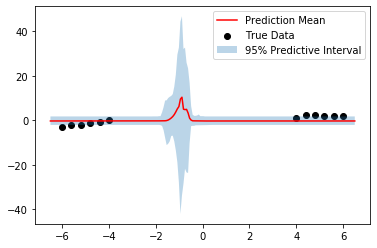

In [14]:
# Read in data
data = np.loadtxt('./data/toy_data.csv', delimiter=',', skiprows=1)
x = data[:,0]
y = data[:,1]

# NN design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1
architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}
rand_state = 0
random = np.random.RandomState(rand_state)

# Instantiate a FeedForward neural network object
bnn = Feedforward(architecture, random=random)

# Flow parameters
num_flows = 4
num_samples = 200
h = np.tanh
D = 2*bnn.D + 1
flow_params = [1.] * D
lambda_flows = np.array([np.array(flow_params)]*num_flows)

# Generate samples
samples = np.random.multivariate_normal([0]*bnn.D, np.eye(bnn.D), num_samples)
print(samples.shape)

# Energy bound from paper
grad_energy_bound = autograd.grad(energy_bound)

# Joint prob of BNN
joint_prob = lambda w: log_joint(w, 0, x, y, 5*np.ones(num_samples), 
                          1/5*np.eye(bnn.D), bnn, bnn.D)

# Fit
output = adam_solve(lambda_flows, grad_energy_bound, samples, joint_prob, h,
                    m=3000, step_size=0.01, bnn=True)

# Predict and plot
print('Figure 11: Posterior Predictive of the BNN posterior with Normalizing Flows')
posterior_predictive(bnn, output, x, y)

### BBVI
We use similarly implement BBVI and train the model on the same set of data as before:

In [15]:
# Code based on Weiwei Pan's AM207 Fall '19 HW8 Solutions
# Read in our toy data
df = pd.read_csv('./data/toy_data.csv')
x_train = df['x'].values
y_train = df['y'].values

# Initialize neural network design
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

# Set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

# Instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

# Define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':5000, 
          'random_restarts':1}

# Fit neural network to minimize MSE on the given data
nn.fit(x_train.reshape((1, -1)), y_train.reshape((1, -1)), params=params)

Iteration 0 lower bound 17.474750771220616; gradient mag: 61.41048917314607
Iteration 100 lower bound 7.749552616494222; gradient mag: 21.46559348985758
Iteration 200 lower bound 5.917150191001728; gradient mag: 8.43257466729395
Iteration 300 lower bound 5.314270007146428; gradient mag: 3.584720221137439
Iteration 400 lower bound 4.967250252774278; gradient mag: 2.913172870829345
Iteration 500 lower bound 4.626727282535146; gradient mag: 3.2866390732417625
Iteration 600 lower bound 4.037804973954416; gradient mag: 3.2974892521576407
Iteration 700 lower bound 3.7807850805407903; gradient mag: 2.992286271019979
Iteration 800 lower bound 3.535984693993644; gradient mag: 2.8012116896646093
Iteration 900 lower bound 3.283280980526814; gradient mag: 2.7010042131319287
Iteration 1000 lower bound 3.05116625417585; gradient mag: 2.538492696125703
Iteration 1100 lower bound 2.831001806980293; gradient mag: 2.3888037504371558
Iteration 1200 lower bound 2.624704957261187; gradient mag: 2.232371535

In [16]:
# Probabilistic model params
Sigma_W = 0.5**2 * np.eye(nn.D)
sigma_y = 0.5**2

# Size of training set
N = len(x_train)

# Bayesian regression parameters
regression_params = {'D_in': 1, 'D_out': 1}

# Regression model
regression = Bayesian_Regression(regression_params, nn.forward, Sigma_W, sigma_y, random=random)

# Fit model
regression.fit(np.vstack((x_train.reshape((1, -1)), y_train.reshape((1, -1)))).T, N)
# Initialize variational mean and variational variance
init_mean = nn.weights.reshape((nn.D, ))
init_var = np.ones(init_mean.shape) * -10
init = np.hstack((init_mean, init_var))

x_test = np.linspace(-8, 8, 100)
y_test = nn.forward(nn.weights, x_test.reshape((1, -1)))

# Define optimization parameters for BBVI
params = {'step_size':1e-3, 
          'max_iteration':10000,
          'random_restarts':1, 
          'params_init':init}

# Sample from the posterior of the Bayesian regression model using BBVI
trace = regression.sample_posterior('vi', params=params)

# Sample from the posterior predictive
regression.sample_posterior_predictive(x_test, samples=1000)
y_preds = regression.posterior_predictive_samples.reshape((-1, 100))

# Compute the 95% predictive interval and the predictive mean
y_postpred_ub = np.percentile(y_preds, 97.5, axis=0).flatten()
y_postpred_lb = np.percentile(y_preds, 2.5, axis=0).flatten()
y_postpred_means = np.apply_along_axis(np.mean, 0, y_preds).flatten()

using bbb
Iteration 0 lower bound -282.5587073542498; gradient mag: 41.47705093833285
Iteration 100 lower bound -272.0530214877293; gradient mag: 40.64909372847098
Iteration 200 lower bound -262.9839209266389; gradient mag: 39.419074126288606
Iteration 300 lower bound -254.67715252335557; gradient mag: 38.442151042490664
Iteration 400 lower bound -246.87299020431038; gradient mag: 37.57270226113858
Iteration 500 lower bound -239.4763937311688; gradient mag: 36.749297002090636
Iteration 600 lower bound -232.4374193620996; gradient mag: 35.97390665532321
Iteration 700 lower bound -225.71939714534446; gradient mag: 35.21598157273964
Iteration 800 lower bound -219.29275497763058; gradient mag: 34.4804963500678
Iteration 900 lower bound -213.13572295719678; gradient mag: 33.773678271457385
Iteration 1000 lower bound -207.22927587237695; gradient mag: 33.0678689697615
Iteration 1100 lower bound -201.5547758623584; gradient mag: 32.368747488644516
Iteration 1200 lower bound -196.0980965192702

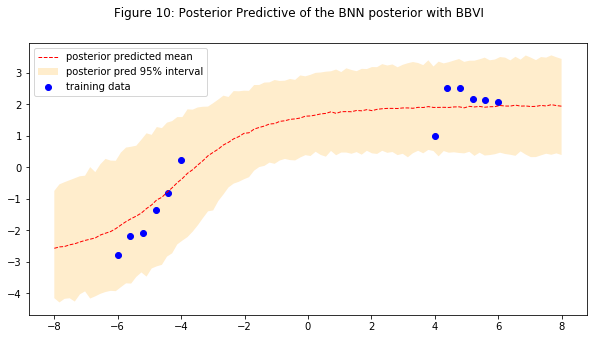

In [17]:
# Visualize 95% posterior predictive interval and posterior predictive mean
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.fill_between(x_test.flatten(), y_postpred_ub, y_postpred_lb, facecolor='orange', interpolate=True, alpha=0.2, label='posterior pred 95% interval')
ax.scatter(x_train, y_train, color='blue', label='training data')
ax.plot(x_test.flatten(), y_postpred_means, color='red', linestyle='--', linewidth=1, label='posterior predicted mean')
ax.legend(loc='best')
plt.suptitle("Figure 12: Posterior Predictive of the BNN posterior with BBVI")
plt.show()


We can compare performance with several other VI implementations

### HMC Sampling
We use similarly implement HMC sampling and train the model on the same set of data as before:



In [18]:
from ref.alpha_hmc import HMC

# As before, read data
df = pd.read_csv('./data/toy_data.csv')
x_train = df['x'].values.reshape((1, -1))
y_train = df['y'].values.reshape((1, -1))

# Define NN parameters
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

rand_state = 0
random = np.random.RandomState(rand_state)

# Instantiate Feedforward neural network object
nn = Feedforward(architecture, random=random)\

# Define params
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

# Fit NN to minimize MSE on the given data
nn.fit(x_train, y_train, params=params)

# Obtain test x
x_test = np.linspace(-8, 8, 100).reshape((1, -1))
#predict on the test x-values
y_test_pred = nn.forward(nn.weights, x_test)


# Covariance matrix of the Gaussian prior on weights
Sigma_W = 5**2 * np.eye(nn.D)

# Gaussian likelihood variance
sigma_y = 0.5**2

# Number of data points
N = 12

# Precision matrix of the Gaussian prior on weights
Sigma_W_inv = np.linalg.inv(Sigma_W)

# Determinant of the covaraince matrix of the Gaussian prior on weights
Sigma_W_det = np.linalg.det(Sigma_W)

###definition of the log prior
def log_prior(W):
    assert len(W.shape) == 2 and W.shape[1] == nn.D
    S = len(W)
    constant_W = -0.5 * (nn.D * np.log(2 * np.pi) + np.log(Sigma_W_det))
    exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
    assert exponential_W.shape == (S, )
    log_p_W = constant_W + exponential_W
    return log_p_W

###definition of the log likelihood
def log_lklhd(W):
    assert len(W.shape) == 2 and W.shape[1] == nn.D
    S = W.shape[0]
    constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * N
    exponential = -0.5 * sigma_y**-2 * np.sum((y_train.reshape((1, 1, N)) - nn.forward(W, x_train))**2, axis=2).flatten()
    assert exponential.shape == (S, )
    return constant + exponential

#potential energy function
def potential_energy(W):
    return -1 * (log_lklhd(W) + log_prior(W))[0]
#kinetic energy function
def kinetic_energy(W):
    return np.sum(W**2) / 2.0
#the gibbs distribution of the kinetic energy function
def kinetic_energy_distribution(n):
    return random.normal(0, 1, size=nn.D)

#initialize the position vector for HMC sampling with the weights of the trained neural network
position_init = nn.weights.reshape((1, nn.D))
#leap-frog step size
step_size = 1e-2
#leap-frog steps
leapfrog_steps = 20
#number of total samples after burn-in
total_samples = 20000
#percentage of samples to burn
burn_in = 0.1
#thinning factor
thinning_factor = 1

#instantiate an HMC sampler
HMC_sampler = HMC(potential_energy, kinetic_energy,
                  kinetic_energy_distribution,
                  random=random)

#sample from the bayesian neural network posterior
HMC_sampler.sample(position_init=position_init,
                   step_size=step_size,
                   leapfrog_steps=leapfrog_steps,
                   total_samples=total_samples,
                   burn_in=burn_in,
                   thinning_factor=thinning_factor)

posterior_samples = HMC_sampler.trace[::100]
total_samples = len(posterior_samples)

y_predict_train_noiseless = nn.forward(posterior_samples, x_train).reshape((total_samples, -1))
y_pred_test = nn.forward(posterior_samples, x_test).reshape((total_samples, -1)) + np.random.normal(0, sigma_y**0.5, size=(total_samples, len(x_test)))

#Gaussian log pdf
gaussian_log_pdf = lambda mu, sigma_sq, x: -0.5 * (np.log(2 * np.pi * sigma_sq) + (x - mu)**2 / sigma_sq)

#compute log likelihood for the training data
log_likelihood = []
for n in range(y_train.shape[1]):
    log_likelihood.append(gaussian_log_pdf(y_train[:, n], sigma_y,  y_predict_train_noiseless[:, n].flatten()).mean())
log_likelihood = np.array(log_likelihood).sum()

Iteration 0 lower bound 17.474750771220616; gradient mag: 61.41048917314607
Iteration 100 lower bound 7.749552616494222; gradient mag: 21.46559348985758
Iteration 200 lower bound 5.917150191001728; gradient mag: 8.43257466729395
Iteration 300 lower bound 5.314270007146428; gradient mag: 3.584720221137439
Iteration 400 lower bound 4.967250252774278; gradient mag: 2.913172870829345
Iteration 500 lower bound 4.626727282535146; gradient mag: 3.2866390732417625
Iteration 600 lower bound 4.037804973954416; gradient mag: 3.2974892521576407
Iteration 700 lower bound 3.7807850805407903; gradient mag: 2.992286271019979
Iteration 800 lower bound 3.535984693993644; gradient mag: 2.8012116896646093
Iteration 900 lower bound 3.283280980526814; gradient mag: 2.7010042131319287
Iteration 1000 lower bound 3.05116625417585; gradient mag: 2.538492696125703
Iteration 1100 lower bound 2.831001806980293; gradient mag: 2.3888037504371558
Iteration 1200 lower bound 2.624704957261187; gradient mag: 2.232371535

Iteration 10200 lower bound 0.07277584566477567; gradient mag: 0.0285560746160078
Iteration 10300 lower bound 0.07246112892531117; gradient mag: 0.007374518121984793
Iteration 10400 lower bound 0.07217819155497307; gradient mag: 0.006730153593129553
Iteration 10500 lower bound 0.07192603724215511; gradient mag: 0.03804588535374429
Iteration 10600 lower bound 0.07170010314630598; gradient mag: 0.00564455441919701
Iteration 10700 lower bound 0.07149438839721554; gradient mag: 0.008650218772631038
Iteration 10800 lower bound 0.07130676826235845; gradient mag: 0.014736065687041772
Iteration 10900 lower bound 0.0711350504460651; gradient mag: 0.005334314760449989
Iteration 11000 lower bound 0.07097586962421194; gradient mag: 0.024878650353908877
Iteration 11100 lower bound 0.07082817999229574; gradient mag: 0.04614835337865516
Iteration 11200 lower bound 0.07068574994162259; gradient mag: 0.005693861739259684
Iteration 11300 lower bound 0.07055102059209348; gradient mag: 0.01001423282923036

HMC 15400: accept rate of 58.91558441558441
HMC 15600: accept rate of 58.756410256410255
HMC 15800: accept rate of 58.94303797468354
HMC 16000: accept rate of 59.10625
HMC 16200: accept rate of 59.15432098765432
HMC 16400: accept rate of 59.27439024390244
HMC 16600: accept rate of 59.433734939759034
HMC 16800: accept rate of 59.464285714285715
HMC 17000: accept rate of 59.529411764705884
HMC 17200: accept rate of 59.58139534883721
HMC 17400: accept rate of 59.5632183908046
HMC 17600: accept rate of 59.55113636363637
HMC 17800: accept rate of 59.449438202247194
HMC 18000: accept rate of 59.455555555555556
HMC 18200: accept rate of 59.3021978021978
HMC 18400: accept rate of 59.11413043478261
HMC 18600: accept rate of 59.13978494623656
HMC 18800: accept rate of 59.18617021276596
HMC 19000: accept rate of 59.21578947368421
HMC 19200: accept rate of 59.177083333333336
HMC 19400: accept rate of 59.2319587628866
HMC 19600: accept rate of 59.275510204081634
HMC 19800: accept rate of 59.3030303

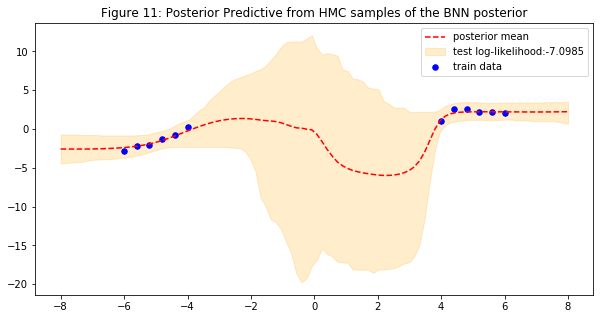

In [19]:
#compute the 95 percentiles and the mean of the posterior predictives
ub_bayes = np.percentile(y_pred_test, 97.5, axis=0)
lb_bayes = np.percentile(y_pred_test, 2.5, axis=0)
mean_bayes = np.mean(y_pred_test, axis=0)

#visualize the posterior predictive distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.fill_between(x_test.flatten(), ub_bayes, lb_bayes, color='orange', alpha=0.2, label='test log-likelihood:{}'.format(np.round(log_likelihood, 4)))
ax.scatter(x_train.flatten(), y_train.flatten(), color='blue', s=30, label='train data')
ax.plot(x_test.flatten(), mean_bayes, '--', color='red', label='posterior mean')

ax.set_title('Figure 13: Posterior Predictive from HMC samples of the BNN posterior')
ax.legend(loc='best')
plt.show()

Comparing the three implmentations, it is clear that our model using normalizing flows leaves much to be desired in terms of performance. That being said, the model is able to satisfactorily generate posterior predictives that align with what we might intuitively expect. It seems like our implementation is able to accommodate for both epistemic and aleatoric uncertainty. Epistemic uncertainty is visually evident through how the 95% predictive interval is much wider in middle where there is no data; meanwhile, aleatoric uncertainty is evident through how the 95% predictive interval exists as a range even in areas where we have data. 

Having said that, our implementation seems to be excessively certain even in areas where of data scarcity where we would expect more epistemic uncertainty than the blue area on figure 11 seems to suggest. The model seems to be overly confident in certain areas that we would have liked it to be. This seems to be still be the case even after we've tried to adjust the model parameters - though it possible that we have not tuned our model finely enough. Another noteworthy point is that the approximation takes quite a significant duration to run; the timing is displayed above, but it is sufficient to provisionally make the claim that unless our implementation is made more efficient, attempting more complex cases with more flows, samples, and/or iterations will take considerably more time and computing power.

The BBVI implementation here arguably performs the worst. We also see that the uncertainty as illustrated by the 95% posterior predictive interval is large and fairly constant across the horizontal axis. This is not what we would hope to see; the model exhibits roughly the same amount of uncertainty in areas with data compared to areas where there is no data. In other words, the BBVI implementation seems to have successfully captured the aleatoric uncertainty of the model, but very little epistemic uncertainty that might arise from a lack of data.

The HMC implementation, on the other hand, performs the best here, as we can clearly observe the area graph narrowing in parts where data is present, and expanding in the middle area where data is absent. The narrow parts reflect the aleatoric uncertainty inherent in the model, whereas the thicker, middle parts reflect the epistemic uncertainty stemming from a lack of data. To be clear, we expect the middle parts to exhibit aleatoric uncertainty as well; the point here is that the epistemic uncertainty is observable here because of how the shape of the area graph in the middle part contrasts with that of parts containing data. We might, as such contend that the HMC implementation provides a better posterior predictive model since it is able to capture both forms of uncertainty (compared to the BBVI implementation).


All in all, the comparison illustrates the relative performance of the three approaches to BNNs for our given toy dataset. It illustrates how our existing model might fall short in comparison to HMC sampling and how it might be better than BBVI in some regards. That being said, this comparison remains of limited utility given how with BNNs, we do not actually visually assess the posterior due to its high dimensionality. All we can try to visualize is the posterior predictive, but this does not give us a good sense of how good our overall posterior approximation is.

---

# Limitations of VI with Normalizing Flows

Briefly, we list some of the limitations of variational inference with normalizing flows based on our experience working with normalizing flows throughout our project. 

Firstly, it seems to be the case that the posterior predictive of that is generated by a BNN using normalizing flows for variational inference doesn't represent uncertainty as accurately as compared to a HMC sampling approach. The latter approach does a significantly better job at prediction and seems to be able to better capture the aleatoric and epistemic uncertainty inherent in the system for our toy example. While it could be the case that with further tuning, the BNN using normalizing flows might generate better posterior predictives, we do not have evidence for such a claim at this juncture.

This leads into our next point: namely, that variational inference with normalizing flows are very sensitive to hyperparameter settings. The number of flows, samples, and iterations significantly impact whether or not the model converges. Additionally, it might be the case that the choice of initial distribution that we pass through our flows might significantly impact the performance of our model; we did not, in our implementation, attempt other distributions. These settings can also greatly impact the computational intensity and, in turn, the time taken. This is also illustrated in our triple-peak example.

Relatedly, based on our trials, it seems like the use of normalizing flows for predictions with BNNs is signficantly more computationally intensive that approaches involving the mean-field approximation. Although Duvenaud et al. (2018) discuss how the transformations involved in normalizing flows might be easier to compute, we find that it is also the case, as evident through our metadata, that the normalizing flows process often requires more iterations in order to arrive at a fit. 

Even so, the normalizing flows approach is still limited in how it is prone to overfitting and getting stuck at locally optimal points.

---

# Conclusion and discussion

Based on our experience executing the project, we find that normalizing flows should be considered a viable alternative method of posterior approximation. It is able to escape the mean-field assumption but it remains unclear whether or not it results in better performance. 

More rigorous testing and comparisons will be required since our present evaluation with BNNs might not be sufficiently in-depth. Further, as mentioned above, BNNs make it difficult to get a strong sense of performance comparisons due to inherent difficulties in assessment and comparison. 

Further, based on our examination of the literature and from our results, there is little evidence to suggest that an approach involving normalizing flows performs significantly better than some of its alternatives. In general, the approach is still relatively new and has not been extensively tested beyond the examples in the paper at the time of writing. As we found in our triple-peak distributions, our normalizing flows implementation certainly works, but reamins imprecise when the number of flows and samples are low. This is illustrative of how it might be trading off flexibility for computational efficiency.

Additionally, it should be noted that it is not the case that normalizing flows are the only approach that does not require mean field approximations. Ialongo et al. (2019) propose one such alternative and normalizing flows for variational inference might do well to be evaluated against said alternatives.

To conclude, we find our implementation of normalizing flows for variational inference to be a general success. We have replicated the work presented by Mohamed and Rezende in their original paper and we have successfully implemented it in the context of a BNN for the purposes of posterior predictions. That being said, there remains a lot more room for exploration and research. The experience has left us with a strong understanding not only of how normalizing flows can be used as a potential alternative in variation inference, but also its inherent limitations. In light of this, we hope to continue examining this area and we hope that our work can be useful to other researchers. 

---

# References
- Blei, D.M., Kucukelbir, A., & McAuliffe, J.D. (2018). Variational Inference: A Review for Statisticians. 	arXiv:1601.00670.
- T. Q. Chen, Y. Rubanova, J. Bettencourt, and D. K. Duvenaud. Neural ordinary differential equations. In Advances in neural information processing systems, pages 6571–6583, 2018.
- Hoffman, M. D., Blei, D. M.,  Chong, W., and Paisley, J. (2013). Stochastic variational inference. Journal
- Ialongo, A., van der Wilk, M., Hensman, J., Rasmussen, C.; Proceedings of the 36th International Conference on Machine Learning, PMLR 97:2931-2940, 2019.
of Machine Learning Research, 14:1303–1347.
- Mohamed, S. and Rezende, J.  (2015). Variational Inference with Normalizing Flows. arXiv:1505.05770 [stat.ML] 
- Neal, R. M. (2012). Bayesian learning for neural networks (Vol. 118). Springer Science & Business Media.
- Pan, Weiwei (2019). Applied Mathematics 207: Advanced Scientific Computing Stochastic Methods for Data Analysis, Inference and Optimization (Fall 2019). Harvard University, Cambridge, Massachusetts.
- Tomczak, J. and Welling, M.; Improving variational auto-encoders using Householder flow. arXiv preprint arXiv:1611.09630, 2016.
- Wainwright, M. J. and Jordan, M. I. (2008). Graphical models, exponential families, and
variational inference. Foundations and Trends in Machine Learning, 1(1-2):1–305.




